<a href="https://colab.research.google.com/github/ruanroloff/my_colab/blob/main/Customer_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#### Imports ########################
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
import warnings
#### Settings #########################
plt.rcParams["figure.figsize"]=15,6
set_config(display = 'diagram')
warnings.filterwarnings('ignore')
### Parameters #######################
N_CLUSTERS = 4

In [ ]:
cohort = pd.read_csv("online_purchases.csv",index_col = 0,parse_dates = ["InvoiceDate"])

In [ ]:
print(f"Dataset contains {cohort.shape[0]} lines and {cohort.shape[1]} columns")

Dataset contains 70864 lines and 8 columns


In [ ]:
cohort.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


In [ ]:
cohort.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


In [ ]:
cohort.dtypes

InvoiceNo               int64
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
dtype: object

In [ ]:
# Utility Functions


def get_month(column):
    
    """Truncate the purchase to the first day of the purchase month
       for simplicity of analysis.
    """
    
    return dt.datetime(column.year,column.month,1)

def get_date(dataframe,column):
    df = dataframe.copy()
    year = df[column].dt.year
    month =  df[column].dt.month
    day =  df[column].dt.day
    
    return year,month,day

def df_to_plotly(df):
    return {'z': df.values.tolist(),
            'x': df.columns.tolist(),
            'y': df.index.tolist()}

def currency_format(column):
        return "${:.1f}".format(column)
    
def rfm_quartiles(dataframe,column):
    if column.startswith("R"):
        metric_labels = range(4,0,-1) # The lower the better
    else:
        metric_labels = range(1,5)    # The higher the better
    quartiles = pd.qcut(dataframe[column],q = 4,labels = metric_labels)
    dataframe[column[:1]] = quartiles.values

# 1. Cohort Analysis

In [ ]:
cohort["Invoice_Month"] = cohort["InvoiceDate"].apply(get_month)

In [ ]:
# Find the Date of the Client First Purchase
grouping = cohort.groupby("CustomerID")["Invoice_Month"]
cohort["Cohort_Month"] = grouping.transform("min")

In [ ]:
cohort.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Invoice_Month,Cohort_Month
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01


In [ ]:
# Create a Column Containing the Total Money Spent per Transaction
cohort["Spend"] = cohort["Quantity"]*cohort["UnitPrice"]

In [ ]:
# Calculates the number of months since the first purchase (CohortIndex)

invoice_year,invoice_month,_ = get_date(cohort,"Invoice_Month")
cohort_year,cohort_month,_ = get_date(cohort,"Cohort_Month")
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
cohort["Cohort_Index"] = years_diff*12 + months_diff + 1

In [ ]:
cohort.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Invoice_Month,Cohort_Month,Spend,Cohort_Index
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01,12.60,7
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01,1.45,3
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01,22.50,1
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01,2.10,1
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01,17.85,4


In [ ]:
# Count monthly active customers for each cohort

grouping = cohort.groupby(["Cohort_Month","Cohort_Index"])
cohort_data = grouping["CustomerID"].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index = "Cohort_Month",
                                columns = "Cohort_Index",
                                 values = "CustomerID")

In [ ]:
cohort_counts

Cohort_Index,1,2,3,4,5,6,7,8,9,10,11,12,13
Cohort_Month,,,,,,,,,,,,,
2010-12-01,716.0,246.0,221.0,251.0,245.0,285.0,249.0,236.0,240.0,265.0,254.0,348.0,172.0
2011-01-01,332.0,69.0,82.0,81.0,110.0,90.0,82.0,86.0,104.0,102.0,124.0,45.0,NaN
2011-02-01,316.0,58.0,57.0,83.0,85.0,74.0,80.0,83.0,86.0,95.0,28.0,NaN,NaN
2011-03-01,388.0,63.0,100.0,76.0,83.0,67.0,98.0,85.0,107.0,38.0,NaN,NaN,NaN
2011-04-01,255.0,49.0,52.0,49.0,47.0,52.0,56.0,59.0,17.0,NaN,NaN,NaN,NaN
2011-05-01,249.0,40.0,43.0,36.0,52.0,58.0,61.0,22.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,207.0,33.0,26.0,41.0,49.0,62.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,173.0,28.0,31.0,38.0,44.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,139.0,30.0,28.0,35.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Calcultes the customers retention rates (%)

cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes,axis = 0)
retention.round(3)*100
retention

Cohort_Index,1,2,3,4,5,6,7,8,9,10,11,12,13
Cohort_Month,,,,,,,,,,,,,
2010-12-01,1.0,0.343575,0.308659,0.350559,0.342179,0.398045,0.347765,0.329609,0.335196,0.370112,0.354749,0.486034,0.240223
2011-01-01,1.0,0.207831,0.246988,0.243976,0.331325,0.271084,0.246988,0.259036,0.313253,0.307229,0.373494,0.135542,NaN
2011-02-01,1.0,0.183544,0.180380,0.262658,0.268987,0.234177,0.253165,0.262658,0.272152,0.300633,0.088608,NaN,NaN
2011-03-01,1.0,0.162371,0.257732,0.195876,0.213918,0.172680,0.252577,0.219072,0.275773,0.097938,NaN,NaN,NaN
2011-04-01,1.0,0.192157,0.203922,0.192157,0.184314,0.203922,0.219608,0.231373,0.066667,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.160643,0.172691,0.144578,0.208835,0.232932,0.244980,0.088353,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.159420,0.125604,0.198068,0.236715,0.299517,0.091787,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.161850,0.179191,0.219653,0.254335,0.098266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.215827,0.201439,0.251799,0.100719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


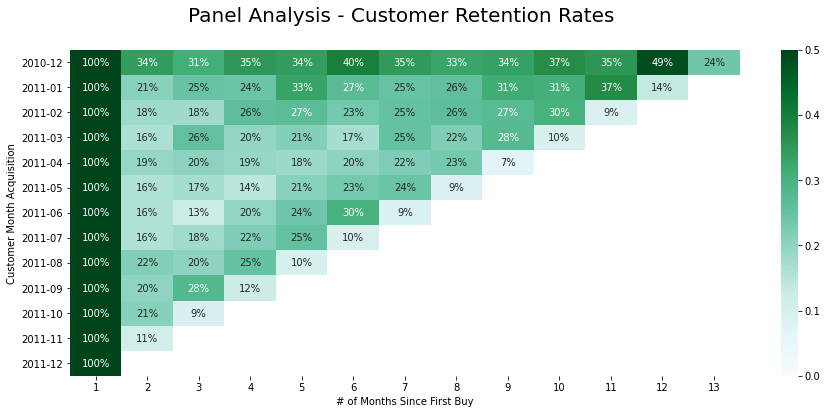

In [ ]:
ax = sns.heatmap(data = retention,
           annot = True,
           fmt = ".0%",
           vmin = 0.0,
           vmax = 0.5,
           cmap = 'BuGn')


_ = ax.set_yticklabels(retention.index.strftime('%Y-%m'))
_ = ax.set_title("Panel Analysis - Customer Retention Rates \n", size = 20)
_= ax.set_ylabel("Customer Month Acquisition")
_ = ax.set_xlabel("# of Months Since First Buy")

In [ ]:
# Count monthly active customers for each cohort

grouping = cohort.groupby(["Cohort_Month","Cohort_Index"])
cohort_data = grouping["Spend"].mean().reset_index()
total_spent_mean = cohort_data.pivot(index = "Cohort_Month",
                                columns = "Cohort_Index",
                                values = "Spend")
total_spent_mean

Cohort_Index,1,2,3,4,5,6,7,8,9,10,11,12,13
Cohort_Month,,,,,,,,,,,,,
2010-12-01,20.823904,19.902873,20.745148,19.544265,18.727043,24.401730,20.978260,21.945392,22.193310,23.284388,28.806344,18.583068,25.375448
2011-01-01,21.432036,18.184403,19.440934,24.598602,26.487684,23.421320,29.640207,29.025451,40.629781,20.467886,21.572219,20.141088,NaN
2011-02-01,18.166968,22.025903,17.157601,19.782206,27.472159,19.384457,25.880923,21.416679,21.665621,24.944229,23.530097,NaN,NaN
2011-03-01,17.477006,19.246418,23.221840,16.106628,19.087807,17.766595,17.997054,20.089602,14.472169,14.591943,NaN,NaN,NaN
2011-04-01,17.178068,19.462939,24.863319,18.284342,18.877091,13.741224,15.435172,17.299054,10.927556,NaN,NaN,NaN,NaN
2011-05-01,21.396581,19.277418,22.030128,19.230318,18.212027,14.252755,16.995796,12.334746,NaN,NaN,NaN,NaN,NaN
2011-06-01,14.562621,19.469444,27.727407,17.163174,14.306449,11.521730,15.338476,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,17.369619,26.326105,10.474592,15.710000,11.149469,8.804701,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,18.007863,14.389574,12.628261,17.250676,13.148537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


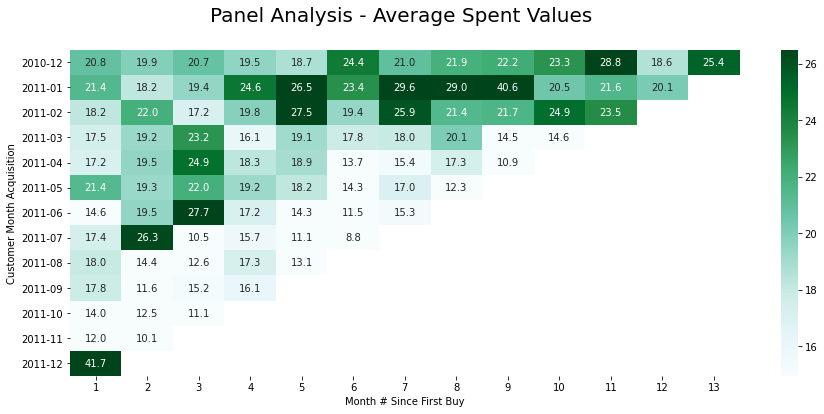

In [ ]:
ax = sns.heatmap(data = total_spent_mean,
           annot = True,
           fmt = ".1f",
           vmin = total_spent_mean.quantile(0.05).mean(),
           vmax = total_spent_mean.quantile(0.95).mean(),
           cmap = 'BuGn')


_ = ax.set_yticklabels(retention.index.strftime('%Y-%m'))
_ = ax.set_title("Panel Analysis - Average Spent Values \n", size = 20)
_= ax.set_ylabel("Customer Month Acquisition")
_ = ax.set_xlabel("Month # Since First Buy")

# 2. RFMT Segmentation

In [ ]:
fake_today = max(cohort.InvoiceDate) + dt.timedelta(days=1)
fake_today

Timestamp('2011-12-10 12:49:00')

In [ ]:
# Data Aggregation to RFM Analysis

rfmt_data = cohort.groupby(["CustomerID"]).agg({
                                               "InvoiceDate":lambda date:(fake_today - date.max()).days,
                                                "InvoiceNo":'count',
                                                "Spend":'sum'
                                              })

# Renaming Columns as RFM acronym

rfmt_data.rename(columns = {"InvoiceDate":"Recency",
                           "InvoiceNo":"Frequency",
                            "Spend":"MonetaryValue"},
                            inplace = True)
rfmt_data.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,27,992.82
12748,1,967,7522.06
12749,4,37,813.45
12820,3,17,268.02
12822,71,9,146.15


In [ ]:
# Let's Aggregate Tenure (T) to the segmentation (number of days as customer)

rfmt_data["Tenure"] = cohort.groupby(["CustomerID"]).agg({"InvoiceDate":lambda date:(fake_today - date.min()).days})
rfmt_data.head()

,Recency,Frequency,MonetaryValue,Tenure
CustomerID,,,,
12747,2,27,992.82,369
12748,1,967,7522.06,370
12749,4,37,813.45,213
12820,3,17,268.02,327
12822,71,9,146.15,87


In [ ]:
# Segmenting the Custormers via RFM Quartiles Distribution

metrics = ["Recency","Frequency","MonetaryValue","Tenure"]

for metric in metrics:
    rfm_quartiles(rfmt_data,metric)
    
rfmt_data.head(10)

,Recency,Frequency,MonetaryValue,Tenure,R,F,M,T
CustomerID,,,,,,,,
12747,2,27,992.82,369,4,4,4,4
12748,1,967,7522.06,370,4,4,4,4
12749,4,37,813.45,213,4,4,4,2
12820,3,17,268.02,327,4,3,3,4
12822,71,9,146.15,87,2,2,3,1
12823,297,1,306.00,297,1,1,3,3
12824,60,6,106.38,60,2,2,2,1
12826,3,17,291.26,365,4,3,3,4
12827,33,2,44.55,44,3,1,1,1


In [ ]:
rfmt_data["RFMT_Segment"] = (
                           rfmt_data["R"].astype(str) + 
                           rfmt_data["F"].astype(str) + 
                           rfmt_data["M"].astype(str) + 
                           rfmt_data["T"].astype(str)
                          )
rfmt_data["RFMT_Score"] = rfmt_data[["R","F","M","T"]].sum(axis=1)
rfmt_data.head()

,Recency,Frequency,MonetaryValue,Tenure,R,F,M,T,RFMT_Segment,RFMT_Score
CustomerID,,,,,,,,,,
12747,2,27,992.82,369,4,4,4,4,4444,16
12748,1,967,7522.06,370,4,4,4,4,4444,16
12749,4,37,813.45,213,4,4,4,2,4442,14
12820,3,17,268.02,327,4,3,3,4,4334,14
12822,71,9,146.15,87,2,2,3,1,2231,8


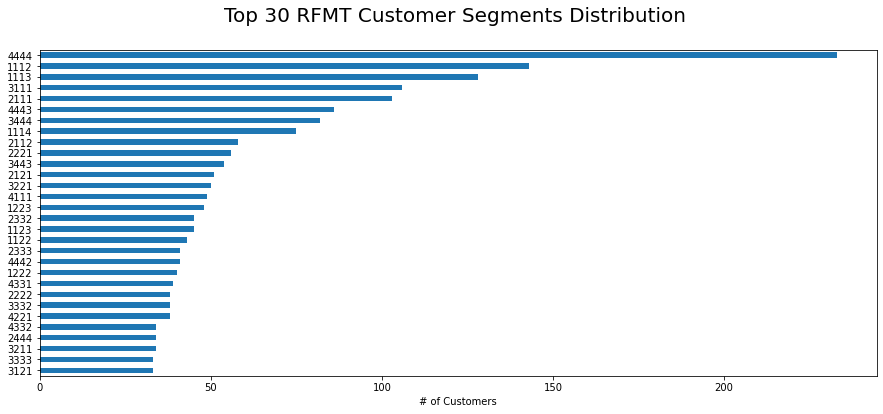

In [ ]:
number_segments = rfmt_data["RFMT_Segment"].nunique()
ax = rfmt_data["RFMT_Segment"].value_counts(ascending=True).tail(30).plot(kind="barh")
_ =ax.set_title("Top 30 RFMT Customer Segments Distribution \n",size = 20)
_ = ax.set_xlabel("# of Customers")

In [ ]:
# RFMT Analysis Summary

rfmt_data.groupby("RFMT_Score").agg({
                                    "Recency":"mean",
                                    "Frequency":"mean",
                                    "MonetaryValue":["mean","count"],
                                    "Tenure":"mean"
                                     })

Recency  Frequency MonetaryValue            Tenure
                  mean       mean          mean count        mean
RFMT_Score                                                       
5           144.487805   2.004065     27.739919   246  144.971545
6           150.384798   2.629454     42.104869   421  155.567696
7           155.444944   4.350562     67.591438   445  168.049438
8           134.930233   6.033592    124.841111   387  166.850129
9           120.253823   8.581040    148.565810   327  186.097859
10           94.579755  11.457055    247.179939   326  213.447853
11           62.611650  15.741100    251.585181   309  210.372168
12           56.157343  20.038462    338.273846   286  250.055944
13           41.444015  29.027027    427.372548   259  273.416988
14           28.206612  36.157025    743.015826   242  299.995868
15           17.736364  49.709091    891.455818   220  330.918182
16            7.407725  88.639485   2210.948498   233  361.051502

# 3. Automatic Clustering

In [ ]:
# Checking the RFM Segments Statistical Properties
rfmt_data.describe()

,Recency,Frequency,MonetaryValue,Tenure,RFMT_Score
count,3701.000000,3701.000000,3701.000000,3701.000000,3701.000000
mean,94.298568,19.147257,380.535069,218.268036,9.938935
std,99.974969,44.831615,1474.285937,118.342940,3.300131
min,1.000000,1.000000,0.650000,1.000000,5.000000
25%,19.000000,4.000000,59.400000,100.000000,7.000000
50%,52.000000,9.000000,140.300000,243.000000,10.000000
75%,151.000000,21.000000,337.800000,321.000000,13.000000
max,374.000000,1532.000000,59596.070000,374.000000,16.000000


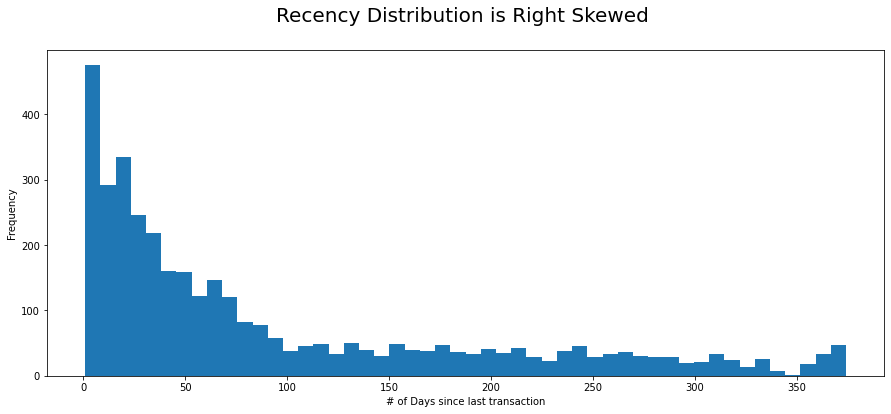

In [ ]:
ax = rfmt_data["Recency"].plot(kind = "hist",bins = 50)
_ = ax.set_title("Recency Distribution is Right Skewed \n", size = 20)
_ = ax.set_xlabel("# of Days since last transaction")

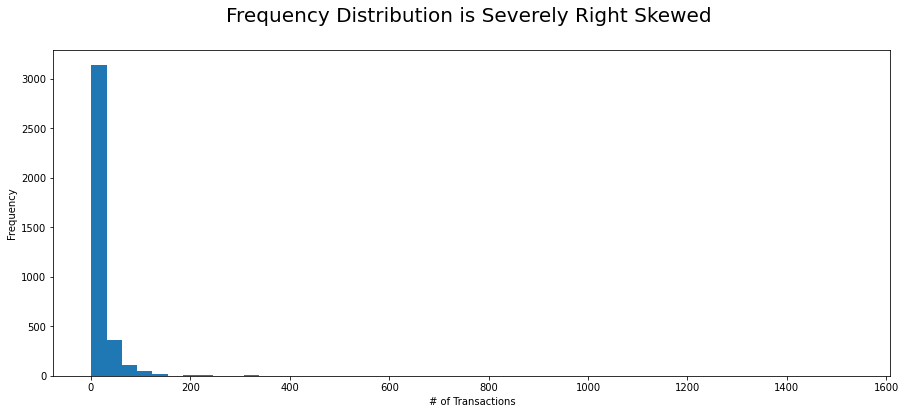

In [ ]:
ax = rfmt_data["Frequency"].plot(kind = "hist",bins = 50)
_ = ax.set_title("Frequency Distribution is Severely Right Skewed \n", size = 20)
_ = ax.set_xlabel("# of Transactions")

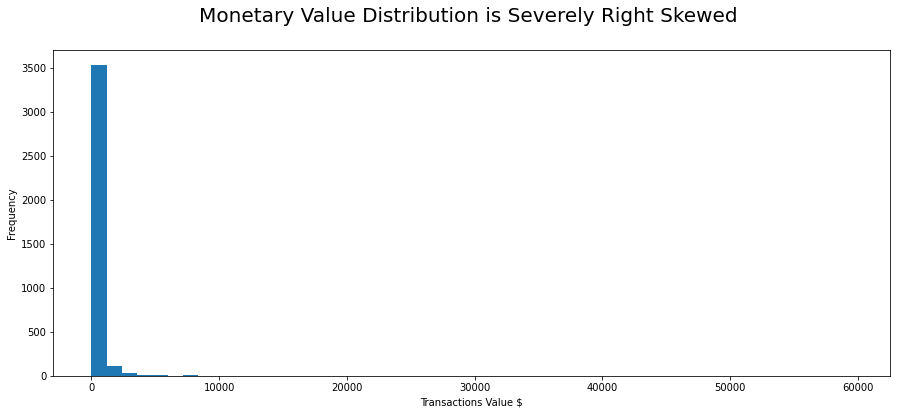

In [ ]:
ax = rfmt_data["MonetaryValue"].plot(kind = "hist",bins = 50)
_ = ax.set_title("Monetary Value Distribution is Severely Right Skewed \n", size = 20)
_ = ax.set_xlabel("Transactions Value $")

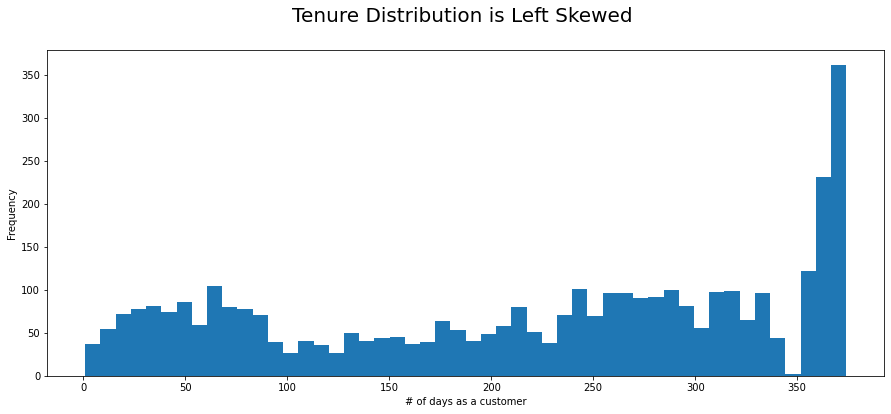

In [ ]:
ax = rfmt_data["Tenure"].plot(kind = "hist",bins = 50)
_ = ax.set_title("Tenure Distribution is Left Skewed \n", size = 20)
_ = ax.set_xlabel("# of days as a customer")

In [ ]:
rfmt_processed = rfmt_data.copy() # keeping the original data untouched from now on

In [ ]:
# RFM log transformation to lower the skewness

for metric in metrics:
    rfmt_processed[metric] = np.log(rfmt_processed[metric])

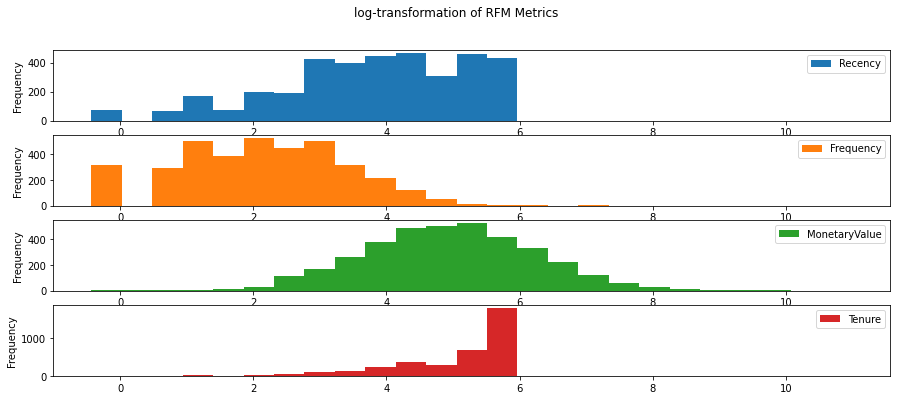

In [ ]:
ax = rfmt_processed[metrics].plot(kind = "hist",
                            bins = 25,
                            subplots=True,
                            sharex = False,
                            title = "log-transformation of RFM Metrics \n")

In [ ]:
customers_data = rfmt_processed[metrics]
customers_data.head()

,Recency,Frequency,MonetaryValue,Tenure
CustomerID,,,,
12747,0.693147,3.295837,6.900549,5.910797
12748,0.000000,6.874198,8.925595,5.913503
12749,1.386294,3.610918,6.701284,5.361292
12820,1.098612,2.833213,5.591062,5.789960
12822,4.262680,2.197225,4.984633,4.465908


In [ ]:
# Kmeans Clustering Pipeline

scaler = StandardScaler() # kmeans needs near equal mean and variance
kmeans = KMeans(n_clusters=N_CLUSTERS,random_state=42)
pipe = make_pipeline(scaler,kmeans)
pipe.fit(customers_data)
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

In [ ]:
# Assigning a label for each customer
cluster_labels = pipe.named_steps.kmeans.labels_

In [ ]:
rfmt_data = rfmt_data.assign(Cluster = cluster_labels)
rfmt_data.head()

,Recency,Frequency,MonetaryValue,Tenure,R,F,M,T,RFMT_Segment,RFMT_Score,Cluster
CustomerID,,,,,,,,,,,
12747,2,27,992.82,369,4,4,4,4,4444,16,0
12748,1,967,7522.06,370,4,4,4,4,4444,16,0
12749,4,37,813.45,213,4,4,4,2,4442,14,0
12820,3,17,268.02,327,4,3,3,4,4334,14,0
12822,71,9,146.15,87,2,2,3,1,2231,8,1


In [ ]:
rfmt_data.groupby("Cluster").agg({
                                    "Recency":"mean",
                                    "Frequency":"mean",
                                    "MonetaryValue":["mean","count"]
                                     }).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          12.0      56.0        1198.0   765
1          90.0      16.0         288.0  1250
2          34.0       7.0         101.0   750
3         215.0       3.0          60.0   936

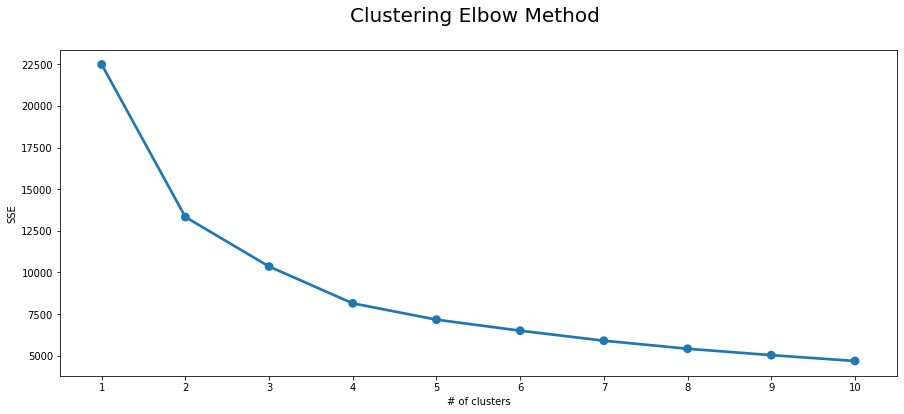

In [ ]:
# Trying to find the optimal number of clusters

sse = {}
number_clusters = 10
for k in range(1,number_clusters + 1):
    kmeans = KMeans(n_clusters = k,random_state = 42)
    kmeans.fit(customers_data)
    sse[k] = kmeans.inertia_
    
ax = sns.pointplot(x = list(sse.keys()),y = list(sse.values()))
_= ax.set_title("Clustering Elbow Method \n", size = 20)
_= ax.set_xlabel("# of clusters")
_= ax.set_ylabel("SSE")

In [ ]:
# tTurning the customer data long (from wide format)
customers_data.loc[:,"Cluster"] = cluster_labels
customers_data_melt = pd.melt(customers_data.reset_index(), 
                                      id_vars=['CustomerID', 'Cluster'],
                                      value_vars=['Recency', 'Frequency', 'MonetaryValue','Tenure'], 
                                      var_name='Metric', value_name='Value')
customers_data_melt.head()

,CustomerID,Cluster,Metric,Value
0,12747,0,Recency,0.693147
1,12748,0,Recency,0.000000
2,12749,0,Recency,1.386294
3,12820,0,Recency,1.098612
4,12822,1,Recency,4.262680


In [ ]:
# Calculate average RFM values for each cluster
cluster_avg = rfmt_data.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = rfmt_data.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = (cluste  n_avg - 1)[metrics]

# Print relative importance score rounded to 2 decimals
relative_imp

,Recency,Frequency,MonetaryValue,Tenure
Cluster,,,,
0,-0.869986,1.911866,2.148520,0.342752
1,-0.047222,-0.172686,-0.243597,0.196382
2,-0.634268,-0.632602,-0.733725,-0.785322
3,1.282337,-0.825074,-0.842765,0.086868


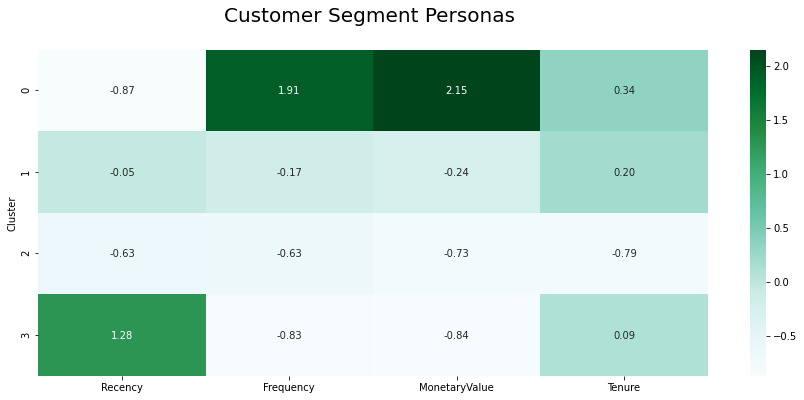

In [ ]:
# Heatmap of Customer Clustered Personas
ax = sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='BuGn')
_= ax.set_title("Customer Segment Personas \n", size = 20)